In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random
import fista
import timeit
from itertools import combinations
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm

float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

# 1. Preliminaries

## Load basis functions

In [2]:
'''Load a dictionary of 300 basis functions, each with
dimensions of 16 x 16 pixels.  (~1.2 times overcomplete)'''

bases = np.load('basis1.npz')['basis']
pixels = 16

## Display 100 basis functions

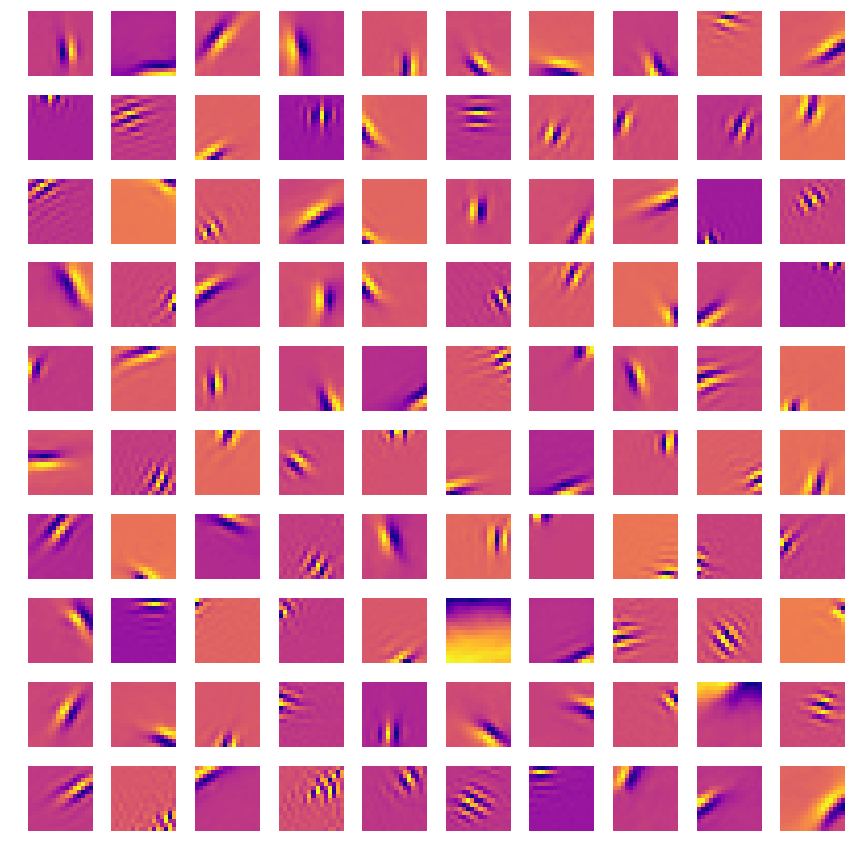

In [3]:
fig, axes = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize = (12,12), facecolor = 'white')
axes = axes.ravel()

for i in range(100):      
    axes[i].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
    axes[i].axis('off')
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

## Load natural images

In [4]:
IMAGES = scipy.io.loadmat('IMAGES.mat')
IMAGES = IMAGES['IMAGES']
(imsize, imsize, num_images) = np.shape(IMAGES)

## Randomly select image patches

In [39]:
def sample_images(sample_size, IMAGES):
    border = 4  #buffer around the edge of an entire image
    imi = np.ceil(num_images * random.uniform(0, 1))  #pick a random image
    I = np.zeros((pixels**2,sample_size))

    for i in range(sample_size):
        r = border + np.ceil((imsize-pixels-2*border) * random.uniform(0, 1))
        c = border + np.ceil((imsize-pixels-2*border) * random.uniform(0, 1))
        image = IMAGES[int(r):int(r+pixels), int(c):int(c+pixels), int(imi-1)]
        I[:,i] = np.reshape(image, pixels**2) 
        
    return I

In [40]:
I = sample_images(10000, IMAGES)

## Find coefficients of sparse representation

In [41]:
ahat = fista.fista(I, bases, lambdav = 0.01, max_iterations=50)

In [8]:
print(np.sum(np.log(1 + ahat**2)))

print(np.sum(I-bases.dot(ahat))**2)

1.64028055676
0.656380122834


In [9]:
ahat_list = np.zeros([100, ahat.shape[0], ahat.shape[1]])

## Compute correlations between neuron pairs; plot as histogram

In [42]:
corr_list = []
neuron_pairs = combinations(range(300),2)

for i,j in neuron_pairs:
    corr = np.corrcoef(ahat[i,:], ahat[j,:])[0, 1]
    corr_list.append(corr)
    #if abs(corr) > 0.4 and i != j:
        #print(i,j)

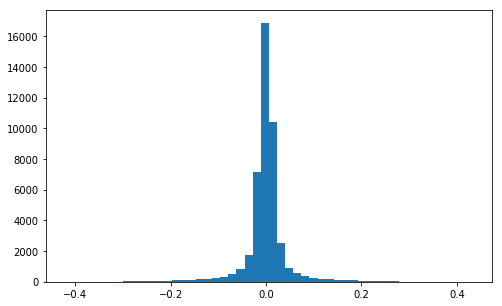

In [152]:
corr_hist = plt.hist(corr_list,50)
plt.show()

0.382198730186


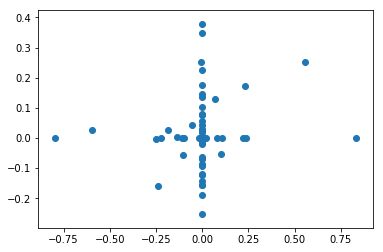

In [92]:
plt.scatter(ahat[56,:], ahat[148,:])
print(np.corrcoef(ahat[58,:], ahat[148,:])[0, 1])
plt.show()

In [12]:
def find_strong_image(neuron1, neuron2):
    for i in range(len(ahat[90,:])):
        if abs(ahat[neuron1,:][i]) > 0.1 and abs(ahat[neuron2,:][i]) > 0.1:
            return(i)
        
def find_strong_images(neuron1, neuron2, cutoff = 0.05):
    image_nums = []
    for i in range(len(ahat[90,:])):
        if abs(ahat[neuron1,:][i]) > cutoff and abs(ahat[neuron2,:][i]) > cutoff:
            image_nums.append(i)
    if len(image_nums) == 0:
        image_nums = find_strong_images(neuron1,neuron2, cutoff = cutoff - 0.05)
    return(image_nums)

In [13]:
print(find_strong_images(58,148))

[3, 5, 41, 96, 118, 124, 134, 143, 145, 166, 192, 200, 221, 252, 267, 273, 276, 300, 311, 336, 351, 401, 406, 417, 423, 449, 512, 517, 528, 543, 549, 597, 605, 607, 624, 638, 662, 667, 677, 686, 693, 699, 728, 753, 754, 758, 771, 774, 777, 782, 801, 802, 815, 818, 843, 855, 860, 861, 869, 917, 926, 927, 929, 936, 955, 956, 958, 964, 979, 983, 990, 994]


In [14]:
def add_noise(image, sigma = 1e-2):
    noise = np.random.normal(0.0, sigma, image.shape)
    return image + noise

def plot_neurons(i,j, responses):
    neuron1 = responses[i,:]
    neuron2 = responses[j,:]
    print(np.corrcoef(neuron1,neuron2)[0, 1])
    plt.scatter(neuron1, neuron2)
    plt.show()

In [23]:
def get_noisy_responses(image):
    for i in range(100):
        ahat_list[i] = fista.fista(add_noise(image, 1e-2), bases, lambdav = 0.1, max_iterations = 50)
    """responses = np.zeros((bases.shape[1], num_trials))
    image_num = find_strong_image(neuron1, neuron2)  
    selected_image = np.reshape(I[:,image_num], (256,1))

    for i in range(num_trials):
        ahat2 = fista.fista(add_noise(selected_image, 1e-2), bases, lambdav = 0.1, max_iterations = 50)
        responses[:, i] = ahat2[:, 0]
        
    corr = np.corrcoef(responses[neuron1,:], responses[neuron2,:])[0, 1]
    
    return(corr)"""
    
def get_noise_correlations(neuron1, neuron2):
    corr = 0
    image_nums = find_strong_images(neuron1, neuron2)
    for image_num in image_nums:
        corr += np.corrcoef(ahat_list[:,neuron1,image_num], ahat_list[:,neuron2,image_num])[0, 1]
    return(corr/len(image_nums))
    

In [16]:
get_noisy_responses(I)

In [17]:
noise_corr_list = []

for neuron1, neuron2 in combinations(range(300),2):
    corr = get_noise_correlations(neuron1, neuron2)
    noise_corr_list.append(corr)

In [36]:
def plot_correlations(noise_corr):
    
    fig, ax = plt.subplots(figsize = (8,5))
    h = ax.hist2d(noise_corr, corr_list,(50,50), cmap = 'plasma', norm = LogNorm())
    m,b = np.polyfit(noise_corr, corr_list, 1)
    ax.plot([-1.0, 1.0], [-m + b, m + b], color='k', linestyle='-', linewidth=2)
    s = 'y = {0:1.2E}x + {1:1.2E}'.format(m,b)
    ax.text(0.05, 0.53, s, fontsize=12)
    plt.xlabel('noise correlation')
    plt.ylabel('signal correlation')
    ax.set_aspect('equal')
    plt.colorbar(h[3])

    #plt.savefig('foo2.png', bbox_inches='tight')
    plt.show()

"""plt.scatter(noise_corr_list, corr_list)
plt.axis('equal')
plt.show()"""

"plt.scatter(noise_corr_list, corr_list)\nplt.axis('equal')\nplt.show()"

In [46]:
print(len(noise_corr_list[0]))

44850


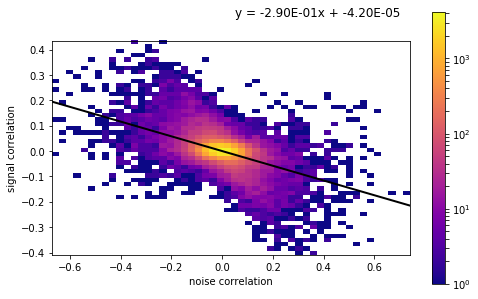

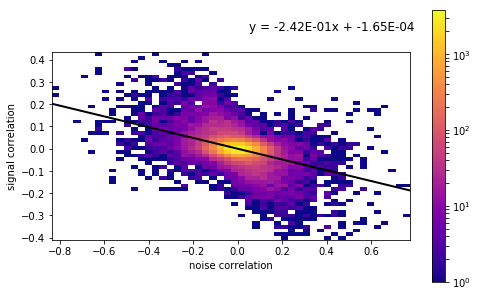

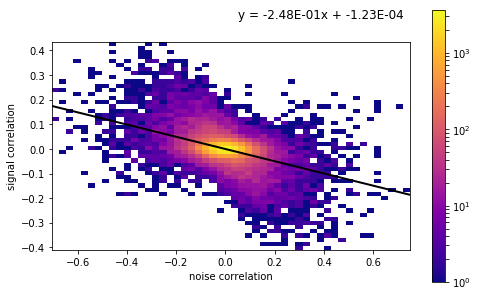

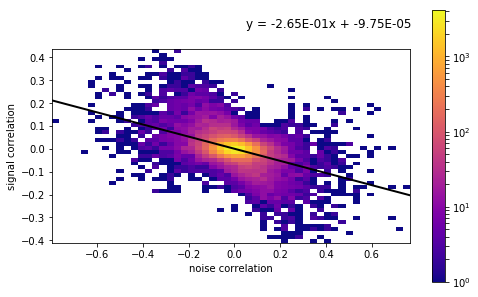

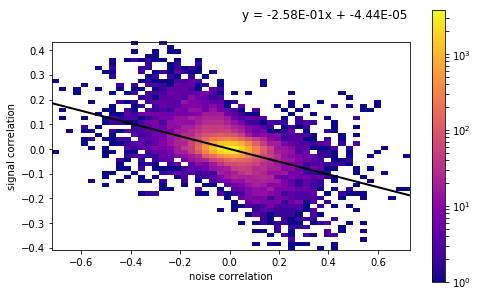

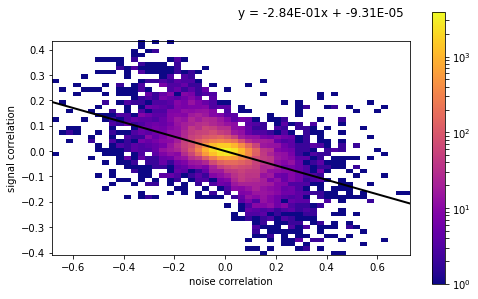

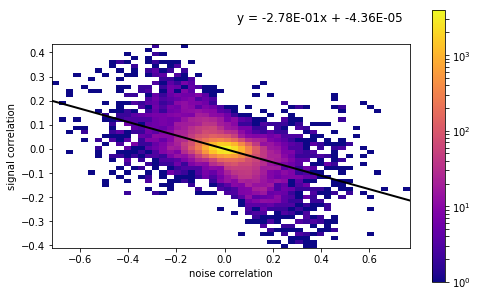

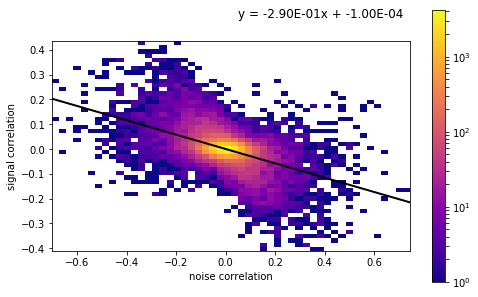

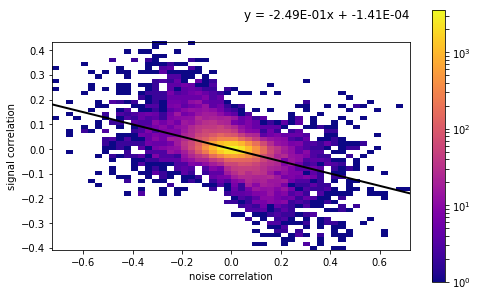

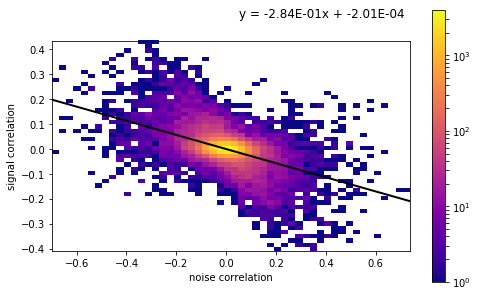

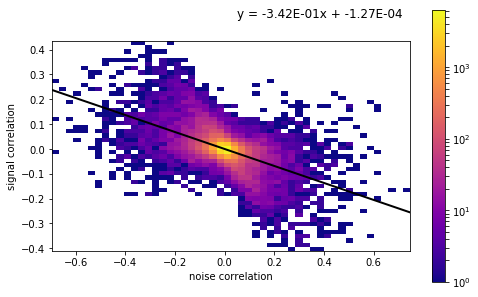

In [48]:
avg_noise_corr_list = np.zeros(44850)
for i in range(10):
    plot_correlations(noise_corr_list[i])
    avg_noise_corr_list += (np.asarray(noise_corr_list[i]))/10.
#plot_correlations(noise_corr_list)
#plot_correlations(noise_corr_listA)
#plot_correlations(noise_corr_listB)
#avg_noise_corr_list = (np.asarray(noise_corr_list) + np.asarray(noise_corr_listA) + np.asarray(noise_corr_listB))/3
plot_correlations(avg_noise_corr_list)

In [202]:
#I = sample_images(1, IMAGES)
ahat = fista.fista(I, bases, lambdav = 0.01, max_iterations=5000)
#ahat = np.random.normal(0.0, 1e-2, size = ahat.shape)
print(U(ahat))
print(I.shape)

0.0494510387522
(256, 1)


In [252]:
#print(0.01*np.sum(np.log(1 + ahat**2)))

grad = 0
for i in range(256):
    im = I[i]
    reco = bases.dot(ahat)[i]
    grad += 2*(im - reco)*(-bases[i,6])
    
print(grad)

#print(bases.shape)
print(np.sum((I - bases.dot(ahat))*(-2*bases), axis = 0))
    

#print(np.sum(np.abs(I-bases.dot(ahat))))

[-0.010]
[0.010 0.007 0.000 0.007 -0.000 -0.010 -0.010 0.005 -0.010 0.008 -0.004
 -0.000 -0.009 0.010 -0.010 -0.010 0.010 0.001 0.003 -0.002 0.010 0.005
 -0.010 -0.000 -0.000 -0.008 0.010 -0.002 -0.003 0.010 0.001 -0.010 0.010
 0.010 -0.010 0.010 0.004 -0.005 -0.010 -0.010 0.010 0.010 -0.010 0.010
 0.010 -0.010 -0.010 0.000 0.010 0.006 -0.005 0.010 -0.010 -0.010 0.010
 -0.010 -0.007 0.008 0.010 -0.010 -0.009 -0.000 -0.006 0.003 -0.009 0.010
 -0.010 0.010 0.010 0.010 -0.003 0.010 -0.010 -0.010 -0.010 -0.004 0.010
 0.010 0.008 0.010 -0.010 0.010 -0.008 -0.010 -0.005 -0.010 -0.002 0.010
 -0.003 -0.002 -0.010 0.010 -0.000 -0.010 -0.010 -0.010 0.010 -0.010 -0.010
 0.009 -0.010 -0.006 0.007 -0.003 -0.010 0.003 -0.010 -0.008 -0.010 -0.010
 0.003 0.010 0.007 0.010 0.010 0.010 0.010 0.010 0.001 -0.006 -0.010 0.010
 -0.006 -0.010 -0.010 0.010 -0.010 0.010 -0.010 0.010 -0.010 0.007 0.010
 0.010 0.009 0.010 -0.010 -0.010 -0.010 0.007 0.001 0.008 0.005 0.010
 -0.010 0.010 0.010 0.010 -0.010 0.010 -

# HMC algorithm

In [8]:
def U(q, Phi = bases, lambdav = 0.01):
    
    return np.sum((I-Phi.dot(q))**2) + lambdav*np.sum(np.log(1 + q**2))

def grad_U(q, Phi = bases, lambdav = 0.01):
    
    grad = np.zeros(q.shape)
    reco_grad = np.sum((I - bases.dot(q))*(-2*bases), axis = 0)
    
    for i in range(300):
        grad[i,:] =  lambdav*2*q[i]/(1 + q[i]**2) + reco_grad[i]

    return(grad)

In [9]:
def HMC(epsilon, L, current_q):
    q = current_q
    p = 1e-2*np.random.normal(size = q.shape)
    current_p = p
    
    # Make a half step for momentum
    
    p += -epsilon*grad_U(q)/2
    
    # Alternate full steps for position and momentum
    
    for i in range(L):
        
        # Make a full step for the position
        
        q += epsilon*p
        
        # Make a full step for momentum, except at end of trajectory
        
        if i != L-1:
            
            p += -epsilon*grad_U(q)
            
    # Make a half step for momentum at the end
    
    p += -epsilon*grad_U(q)/2
    
    
    current_U = U(current_q)
    current_K = np.sum(current_p**2) / 2
    proposed_U = U(q)
    proposed_K = np.sum(p**2) / 2
    
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    #print(np.exp(current_U-proposed_U+current_K-proposed_K))

    if (np.random.uniform() < np.exp(current_U-proposed_U+current_K-proposed_K)):
        
        return q #accept
    
    else:
        return current_q # reject


In [196]:
sample=ahat
samplelist10 = np.zeros([100,300,1])
print(U(sample, bases, 0.01))
energies = []

4.62338490877


In [205]:
for i in range(500):
    
    if i % 20 ==0:
        print(U(sample, bases, 0.01))
    #samplelist[i,:,:] = sample
    #energies.append(U(sample, bases, 0.01))
    sample = HMC(0.1,25, sample)
   

0.094395242937
0.0914186884719
0.0950989829546
0.090886317701
0.0907847270519
0.0879836746189
0.0892740250597
0.0885676523062
0.0855448301445
0.084472607794
0.0827417279525
0.0827019523401
0.0837625609283
0.0815229430289
0.0809692450673
0.0840406591862
0.0833611301808
0.0819441374444
0.0790627748989
0.0790037862104
0.0789758386386
0.0828137803584
0.0792089848564
0.0752877049618
0.0762266537837


In [27]:
BRC_samplesA = np.load('samplesA.npy')
print(BRC_samplesA.shape)

IA = np.load('selected_imageA.npy')

BRC_samplesB = np.load('samplesB.npy')
print(BRC_samplesB.shape)

IB = np.load('selected_imageB.npy')

sample_list = []
image_list = []
for i in range(10):
    sample_list.append(np.load('sample_list%d.npy' % i))
    image_list.append(np.load('selected_image%d.npy' % i))

print(sample_list[0].shape)

(10000, 300, 1)
(10000, 300, 1)
(10000, 300, 1)


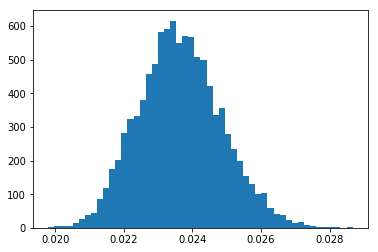

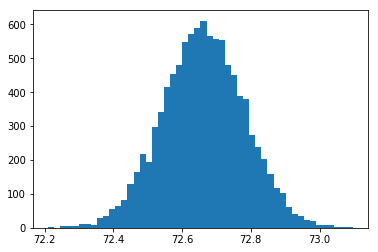

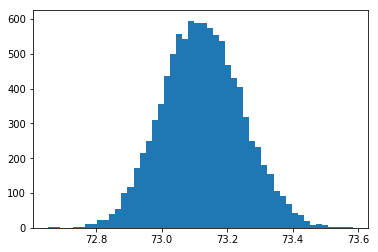

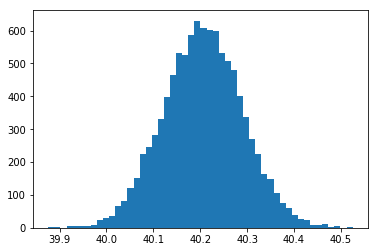

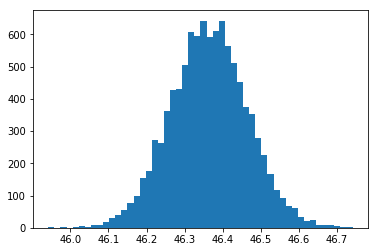

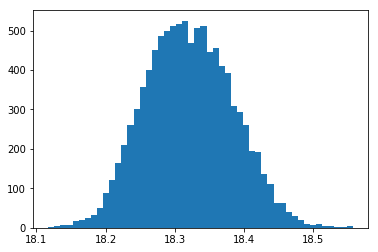

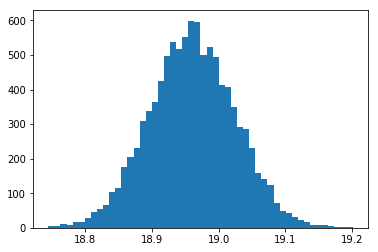

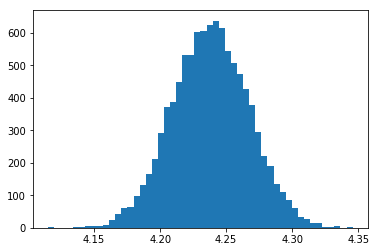

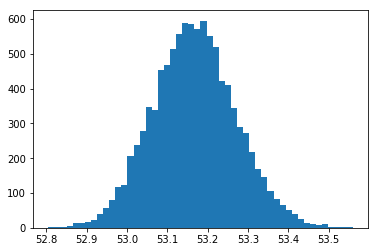

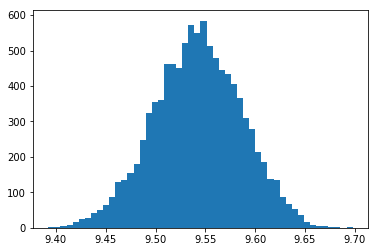

In [28]:
"""I = IA
energies = []
for i in range(10000):
    energies.append(U(BRC_samplesA[i,:,:], bases, 0.01))

plt.hist(energies,bins=50)
plt.show()

I = IB
energies = []
for i in range(10000):
    energies.append(U(BRC_samplesB[i,:,:], bases, 0.01))

plt.hist(energies,bins=50)
plt.show()"""

for i in range(10):
    energies = []
    for j in range(10000):
        energies.append(U(sample_list[i][j,:,:], bases, 0.01))

    plt.hist(energies,bins=50)
    plt.show()

0.00600115296947
0.00689916869931
0.00542935740186
0.00696294689429
0.00277752755468
0.00836342541139
0.0108447093726
0.00729508950663
0.00678732111972
0.0067489751068
[[0.006]
 [0.007]
 [0.005]
 [0.007]
 [0.003]
 [0.008]
 [0.011]
 [0.007]
 [0.007]
 [0.007]]


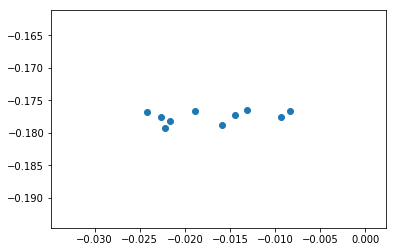

In [71]:
for j in samplelist:
    print(j[1][0])

print(samplelist[:,1,:])
plt.scatter(samplelist[:,4,:],samplelist[:,5,:])
plt.show()

In [32]:
def get_noise_correlations(neuron1, neuron2, noisy_responses):
    #plt.scatter(noisy_responses[:,neuron1,0],noisy_responses[:,neuron2,0])
    #plt.show()
    corr = np.corrcoef(noisy_responses[:,neuron1,0],noisy_responses[:,neuron2,0])[0, 1]
    #print(corr)
    return(corr)
    

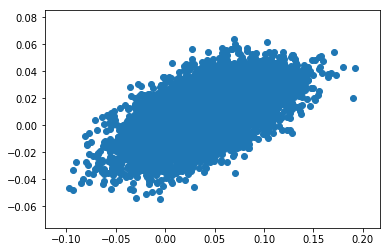

0.582306378804


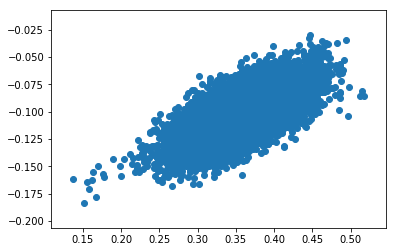

0.683361833627


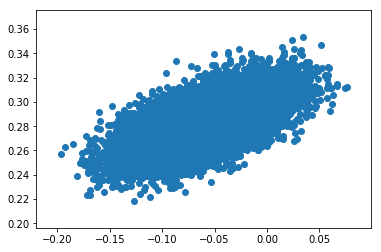

0.620790667634


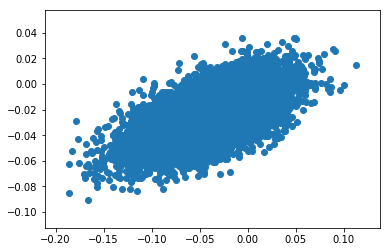

0.58751833525


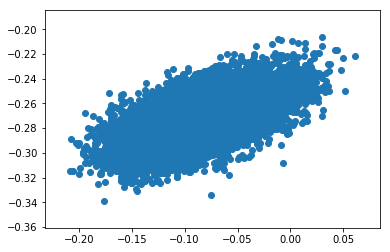

0.61674552478


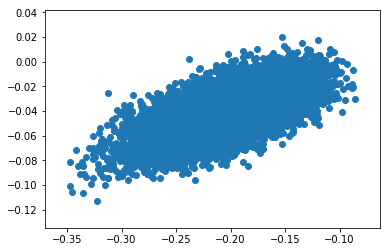

0.634528552944


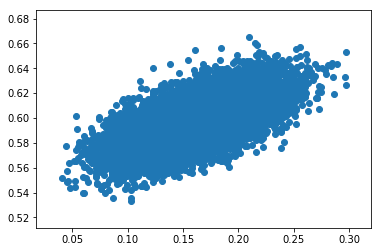

0.629756240788


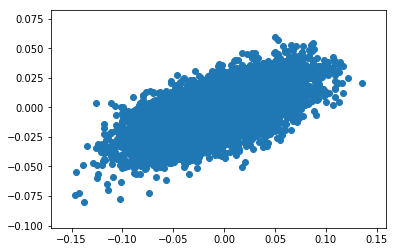

0.641352441949


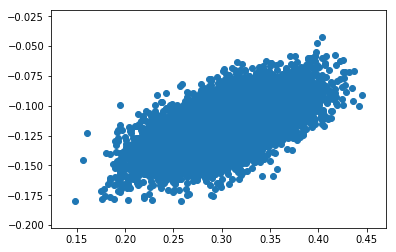

0.613266798066


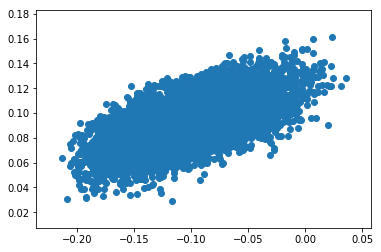

0.61885793137


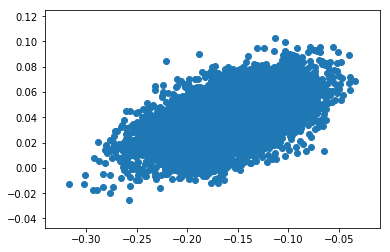

0.53970763515


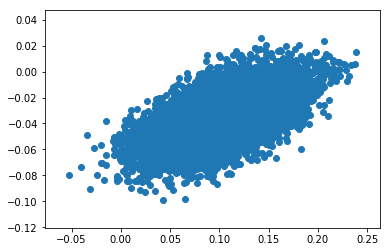

0.598106378901


0.59810637890131668

In [30]:
#get_noise_correlations(125,269,BRC_samples)

for i in range(10):
    get_noise_correlations(125,269,sample_list[i])
    
get_noise_correlations(125,269,BRC_samplesA)
get_noise_correlations(125,269,BRC_samplesB)


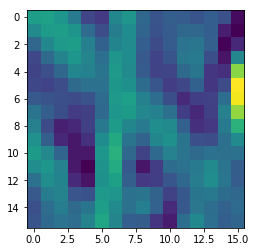

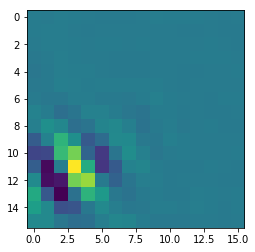

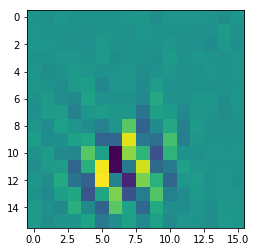

In [143]:
pixels = 16
plt.imshow(np.reshape(I[:,0], (pixels, pixels)))
plt.show()
plt.imshow(np.reshape(bases[:,191], (pixels, pixels)))
plt.show()
plt.imshow(np.reshape(bases[:,149], (pixels, pixels)))
#plt.imshow(np.reshape(add_noise(I[:,1894], 0.1), (pixels,pixels)))
plt.show()

In [34]:
noise_corr_list = []
for i in range(10):
    temp_list = []
    for neuron1, neuron2 in combinations(range(300),2):
        corr = get_noise_correlations(neuron1, neuron2, sample_list[i])
        temp_list.append(corr)
    noise_corr_list.append(temp_list)

In [194]:
def fancy_scatter(x,y):    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=50, edgecolor='')
    plt.show()

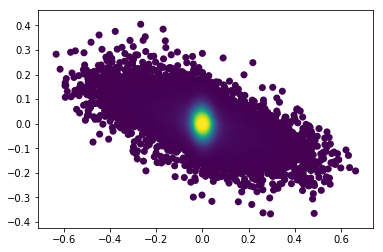

In [202]:
x = np.array(noise_corr_list)
y = np.array(corr_list)
fancy_scatter(x,y)

[-0.111 -0.132 -0.157 -0.112 -0.127 -0.139 -0.158 -0.179 -0.111 -0.150
 -0.164 -0.145 -0.155 -0.171 -0.147 -0.149 -0.149 -0.155 -0.159 -0.151
 -0.154 -0.141 -0.133 -0.127 -0.166 -0.147 -0.168 -0.152 -0.138 -0.127
 -0.166 -0.154 -0.153 -0.134 -0.139 -0.113 -0.120 -0.129 -0.156 -0.160
 -0.156 -0.168 -0.137 -0.148 -0.149 -0.153 -0.164 -0.148 -0.145 -0.153
 -0.156 -0.147 -0.129 -0.172 -0.145 -0.141 -0.138 -0.129 -0.124 -0.139
 -0.133 -0.179 -0.130 -0.134 -0.131 -0.110 -0.161 -0.133 -0.160 -0.146
 -0.140 -0.146 -0.128 -0.152 -0.103 -0.164 -0.143 -0.132 -0.129 -0.139
 -0.111 -0.140 -0.132 -0.121 -0.159 -0.149 -0.140 -0.134 -0.124 -0.114
 -0.130 -0.156 -0.175 -0.125 -0.150 -0.126 -0.126 -0.126 -0.158 -0.149]


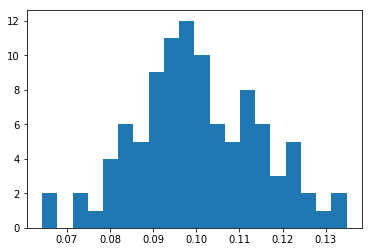

In [119]:
print(ahat_list[:,0,3])
plt.hist(ahat_list[:,0,8], 20)
plt.show()

-0.295571891613


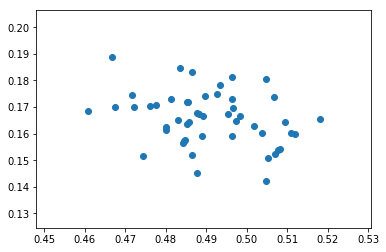

In [74]:
plot_neurons(58,148, responses)

# Signal correlation vs noise correlation

In [84]:
noise_corr_list = []

for neuron1, neuron2 in combinations(range(300),2):
    noise_corr_list.append(get_noise_correlation(neuron1, neuron2))
    

KeyboardInterrupt: 

In [ ]:
corr_hist = plt.hist(noise_corr_list,50)
plt.show()

## Extras

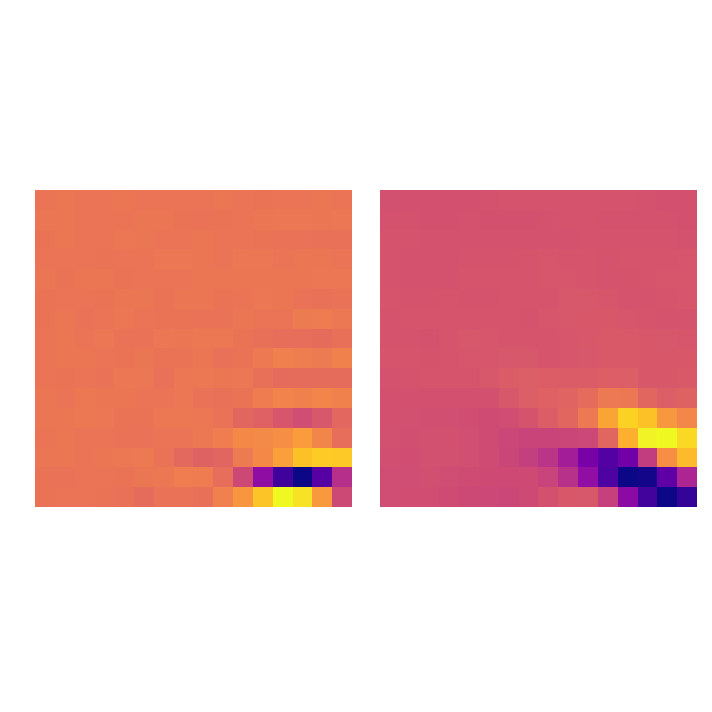

In [50]:
num_images = 15
pixels = 16

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (10,10), facecolor = 'white')

axes = axes.ravel()
j = 0
for i in [67,81]:      
    axes[j].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
    axes[j].axis('off')
    j += 1
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

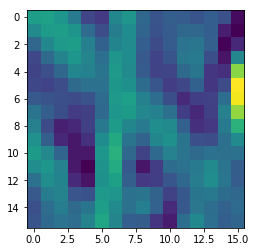

In [117]:
pixels = 16
plt.imshow(np.reshape(I[:,0], (pixels, pixels)))
#plt.imshow(np.reshape(add_noise(I[:,1894], 0.1), (pixels,pixels)))
plt.show()

0.111577397261


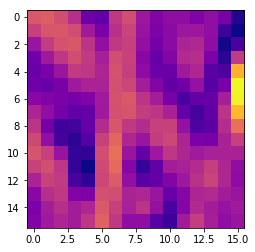

0.100234509818


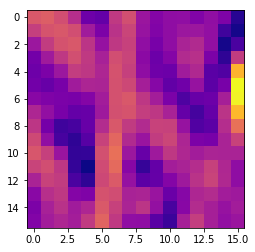

In [120]:


reco = np.dot(bases, ahat[:,0])
print(U(ahat))
plt.imshow(np.reshape(reco, (pixels,pixels)), cmap = 'plasma')
plt.show()

reco = np.dot(bases, BRC_samples[1000,:,:])
print(U(BRC_samples[0,:,:]))
plt.imshow(np.reshape(reco, (pixels,pixels)), cmap = 'plasma')
plt.show()

In [65]:
for i in range(100):
    print(energies[i], U(samplelist[i,:,:], bases, 0.01))
    
print(len(energies))
print(samplelist.shape)

0.238492400824 0.238492400824
0.238579461131 0.238579461131
0.239347658791 0.239347658791
0.238514043766 0.238514043766
0.239475659794 0.239475659794
0.239202585775 0.239202585775
0.23817538769 0.23817538769
0.238423059121 0.238423059121
0.238687390558 0.238687390558
0.238576534198 0.238576534198
0.239010493717 0.239010493717
0.239308027288 0.239308027288
0.238375580994 0.238375580994
0.237616362875 0.237616362875
0.238896214945 0.238896214945
0.237431992479 0.237431992479
0.238146348153 0.238146348153
0.237579887867 0.237579887867
0.238869298442 0.238869298442
0.239292312047 0.239292312047
0.238713403267 0.238713403267
0.238043226092 0.238043226092
0.239003588003 0.239003588003
0.239058048554 0.239058048554
0.238834791511 0.238834791511
0.239252163117 0.239252163117
0.239760454381 0.239760454381
0.240347659279 0.240347659279
0.239045069251 0.239045069251
0.237588911945 0.237588911945
0.237705192229 0.237705192229
0.238687049467 0.238687049467
0.237937885477 0.237937885477
0.2393181484

In [53]:
print(ahat.shape)

(300, 1000)


67
81
159
190
203
264


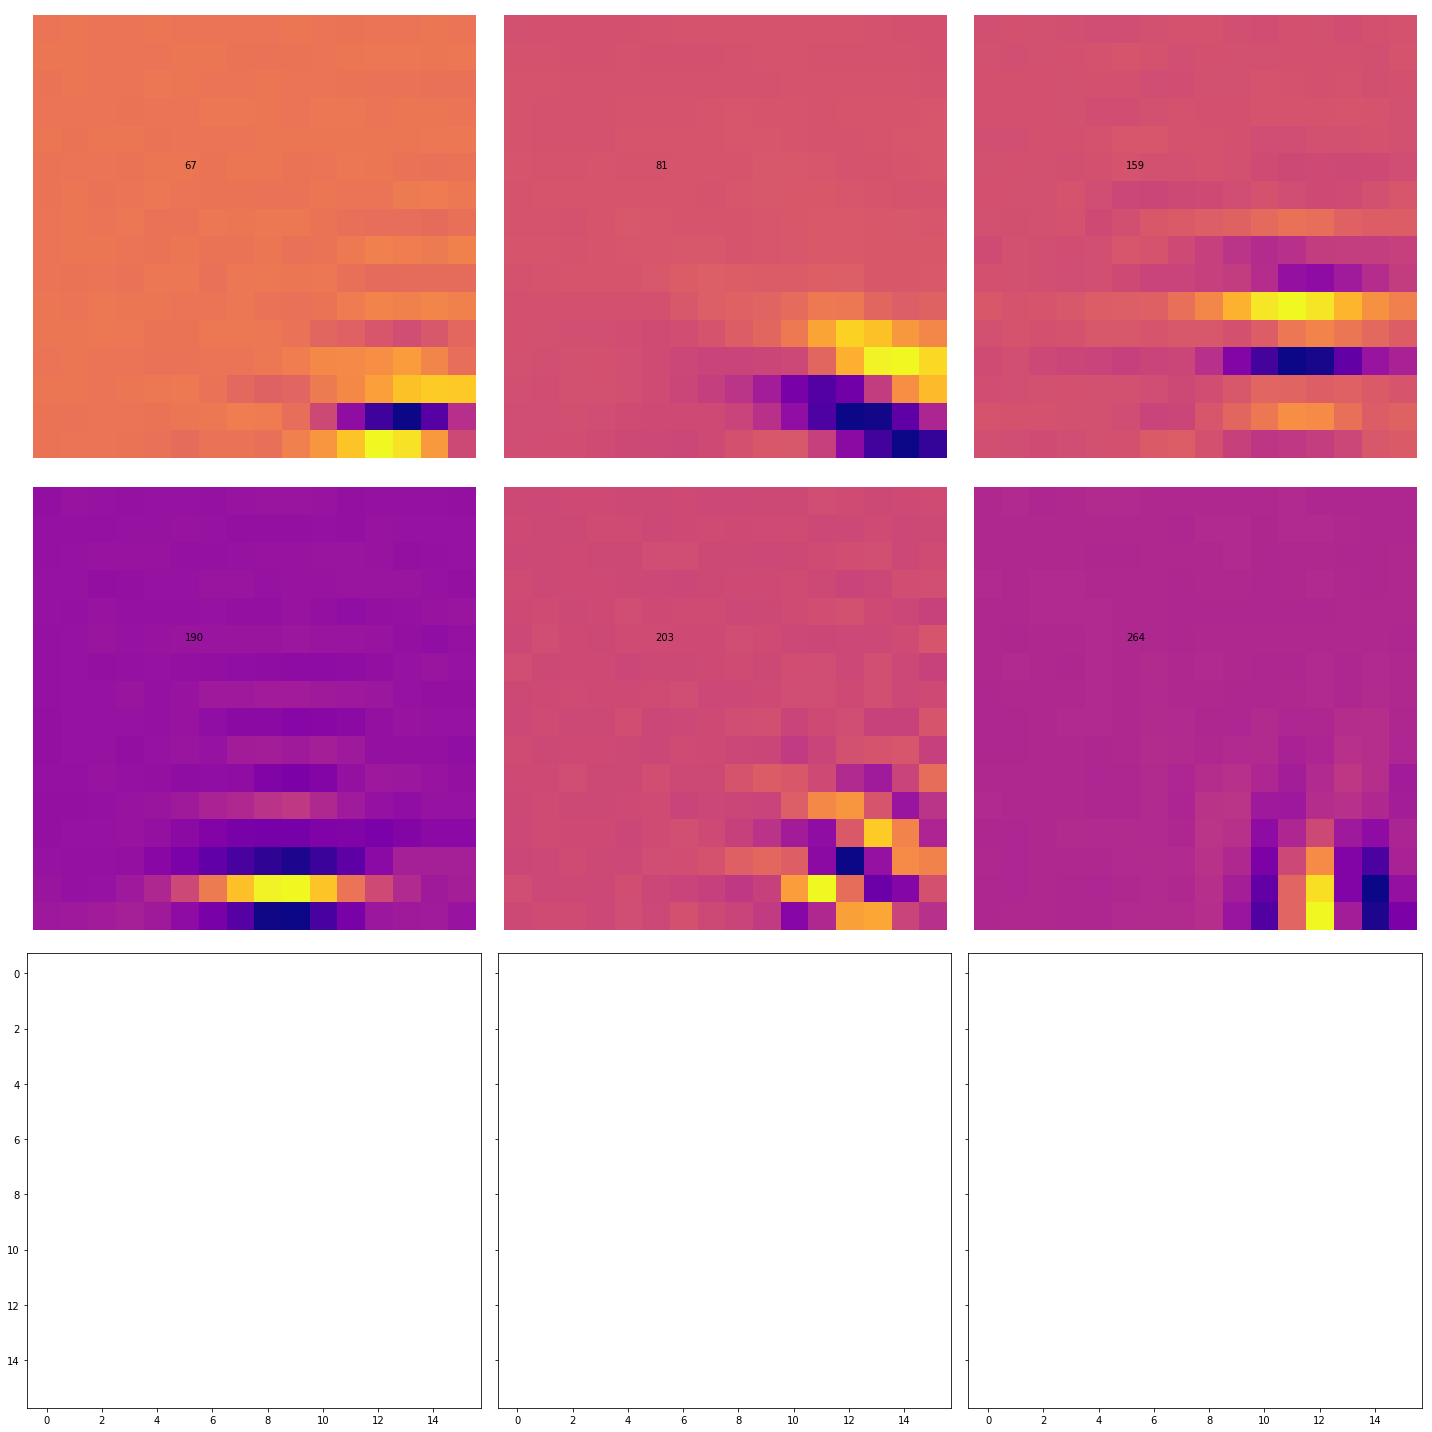

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize = (20,20), facecolor = 'white')
j = 0
partial_reco = np.zeros(256)
axes = axes.ravel()
for i in range(len(ahat)):  
    if abs(ahat[i,835]) > 0.3:
        print(i)
        #partial_reco += ahat[i]*bases[:,i]
        axes[j].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
        axes[j].text(5,5,str(i))
        axes[j].axis('off')
        j += 1
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

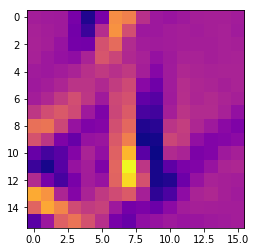

In [74]:
plt.imshow(np.reshape(partial_reco, (pixels, pixels)), cmap = 'plasma')
plt.show()

In [47]:
sums = []
thresh = np.arange(0,1,0.005)
for i in thresh:
    sums.append(np.sum(np.abs(ahat)>i))

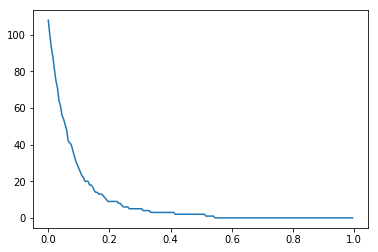

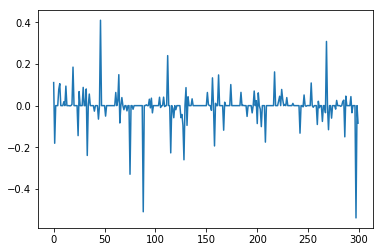

In [33]:
plt.plot(thresh, sums)
plt.show()
plt.plot(ahat)
plt.show()

In [81]:
x = range(10)
array = np.asarray(x)
np.save('arr_file.npy', array)

In [82]:
test = np.load('arr_file.npy')

In [83]:
print(test)

[0 1 2 3 4 5 6 7 8 9]


In [84]:
print(array)

[0 1 2 3 4 5 6 7 8 9]
